In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Conv1D,GlobalMaxPooling1D,MaxPooling1D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer


from numpy import array
from numpy import asarray
from numpy import zeros

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/
%cd 'My Drive'
%cd Colab\ Notebooks
%cd NLP_Assignment/
!ls

/content/drive
/content/drive/My Drive
/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks/NLP_Assignment
best_validation_weights.h5	      movie_data.csv
glove.6B.100d.txt		      test.txt
hin_eng.json			      train.txt
hin_eng_mixed_sentiment_word2vec.txt  words_not_found.txt
model.png


#Pre-processing

In [4]:
fs_train = open('train.txt','r')
arr_train = fs_train.readlines()
sent_words_train = []
temp_train = []
for i in range(len(arr_train)-1):
  if('meta' not in arr_train[i+1]):
    temp_train.append(arr_train[i])
  else:
    sent_words_train.append(temp_train)
    temp_train = []

y_temp = []
x_temp = []

for i in sent_words_train:
  
  y_temp.append(i[0])
  x_temp.append(i[1:])

x_temp2 = []
for i in x_temp:
  tmp = []
  for j in i:
    s = j.split('\t')
    tmp.append(s[0])
  x_temp2.append(' '.join(tmp))

# x_temp2
y_temp2 = []
for i in y_temp:
  s = i.split('\t')
  if(s[-1][:-1]=='negative'):
    y_temp2.append(0)
  elif(s[-1][:-1]=='neutral'):
    y_temp2.append(1)
  else:
    y_temp2.append(2)

# y_temp2

x_train = []
for i in x_temp2:
  m = re.sub(r'@','',i)
  x_train.append(re.sub(r'https.*$','',m))

# y_temp2

y_train = keras.utils.to_categorical(y_temp2, num_classes=None, dtype='float32')
len(x_train)

x_tt = []
for i in x_train:
  x_tt.append(i.split())

fs_test = open('test.txt','r')
arr_test = fs_test.readlines()
sent_words_test = []
temp_test = []
for i in range(len(arr_test)-1):
  if('meta' not in arr_test[i+1]):
    temp_test.append(arr_test[i])
  else:
    sent_words_test.append(temp_test)
    temp_test = []

y_temp = []
x_temp = []

for i in sent_words_test:
  
  y_temp.append(i[0])
  x_temp.append(i[1:])

x_temp2 = []
for i in x_temp:
  tmp = []
  for j in i:
    s = j.split('\t')
    tmp.append(s[0])
  x_temp2.append(' '.join(tmp))

# x_temp2
y_temp2 = []
for i in y_temp:
  s = i.split('\t')
  if(s[-1][:-1]=='negative'):
    y_temp2.append(0)
  elif(s[-1][:-1]=='neutral'):
    y_temp2.append(1)
  else:
    y_temp2.append(2)

# y_temp2

x_test = []
for i in x_temp2:
  m = re.sub(r'@','',i)
  x_test.append(re.sub(r'https.*$','',m))

# y_temp2

y_test = keras.utils.to_categorical(y_temp2, num_classes=None, dtype='float32')

len(x_test)
 

1869

In [5]:
import gensim 
EMBEDDING_DIM = 100
# train word2vec model
model = gensim.models.Word2Vec(sentences=x_tt, size=EMBEDDING_DIM, window=5, workers=4, min_count=1)
# vocab size
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 53353


In [6]:
# save model in ASCII (word2vec) format
filename = 'hin_eng_mixed_sentiment_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train+x_test)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
# x_train

In [8]:
vocab_size_train = len(tokenizer.word_index) + 1
maxlen = 100
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
vocab_size_train

47534

In [0]:
maxlen = 100
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

#GETTING EMBEDDING DICTIONARY

In [0]:
embeddings_dictionary_train = {}
f = open('hin_eng_mixed_sentiment_word2vec.txt',  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_dictionary_train[word] = coefs
f.close()

In [11]:
count = 0
words_not_found = []
embedding_matrix_train = zeros((vocab_size_train, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary_train.get(word)
    if embedding_vector is not None:
        embedding_matrix_train[index] = embedding_vector
    else:
      count+=1
      words_not_found.append(word)

count
# words_not_found

15695

#Recall,F1,Precision

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#MODEL

In [13]:
model = Sequential()
model.add(Embedding(vocab_size_train, 100, weights=[embedding_matrix_train], input_length=maxlen))
model.add(Conv1D(128, 8, activation='relu',padding='same'))
model.add(Dropout(0.3))
model.add(Conv1D(128, 16, activation='relu',padding='same'))
model.add(Dropout(0.3))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
# loss1 = 'binary_crossentropy'
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




#Model training

In [14]:
model.fit(x_train, y_train, batch_size=128, epochs=12, verbose=1, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 12105 samples, validate on 3027 samples
Epoch 1/12
12105/12105 [==============================] - 4s 322us/step - loss: 1.0392 - acc: 0.4657 - f1_m: 0.2659 - precision_m: 0.5486 - recall_m: 0.1832 - val_loss: 1.0046 - val_acc: 0.5061 - val_f1_m: 0.0276 - val_precision_m: 0.6277 - val_recall_m: 0.0142
Epoch 2/12
12105/12105 [==============================] - 1s 95us/step - loss: 0.9436 - acc: 0.5302 - f1_m: 0.3803 - precision_m: 0.6051 - recall_m: 0.2840 - val_loss: 0.9470 - val_acc: 0.5388 - val_f1_m: 0.2206 - val_precision_m: 0.6660 - val_recall_m: 0.1331
Epoch 3/12
12105/12105 [==============================] - 1s 95us/step - loss: 0.8882 - acc: 0.5695 - f1_m: 0.4676 - precision_m: 0.6403 - recall_m: 0.3712 - val_loss: 0.9178 - val_acc: 0.5600 - val_f1_m: 0.3588 - val_precision_m: 0.6740 - val_recall_m: 0.2464
Epoch 4/12
12105/12105 [==============================] - 1s 96us/step 

#Accuracy

In [15]:
acc = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy =",acc[1])
print("F1_score =",acc[2])
print("Precision =",acc[3])
print("Recall =",acc[4])

1869/1869 [==============================] - 0s 114us/step
Accuracy = 0.5179240237333482
F1_score = 0.5053663498708563
Precision = 0.5307031879774576
Recall = 0.4831460676070775


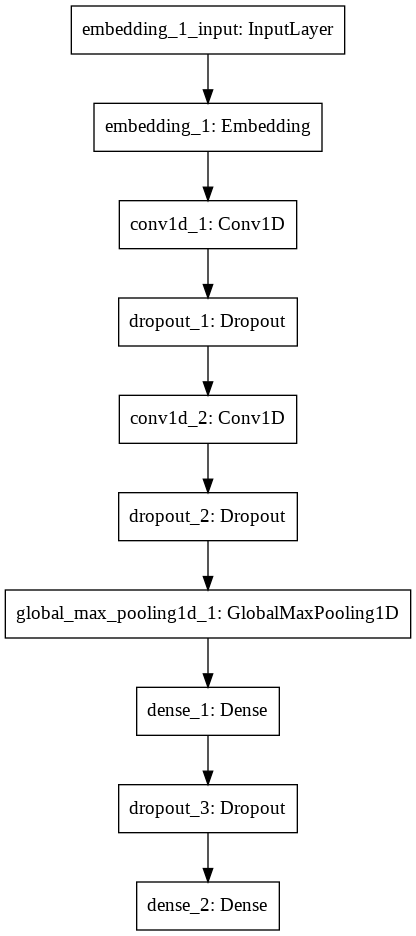

In [16]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')